# Lab 4
### Introduction to Machine Learning, 2021-2022 period 4

This assignment is to be done with a partner. Please only submit ONE .ipynb (not .py) file per pair!

There are **11** problems in this assignment

**Total points: 10**

**Deadline: 2022-06-17 17:00**

**Write your names and student ids here before submission: Thijmen van der Meijden 1670786 & Max Geraedts 2048523**

---

# Introduction

In this laboratory we will experiment with text classification. The inputs to our machine learning models will be texts, each of which has a label (0 or 1). The model is trained to classify new texts as 0 or 1. In particular, we will use the dataset from the shared task *Presupposed Taxonomies: Evaluating Neural Network Semantics (PreTENS)*, part of the SemEval 2022 conference:

https://sites.google.com/view/semeval2022-pretens

The data consists of simple sentences, such as these:

    * I like trees, and in particular birches
    * I like oaks, and in particular trees
    
Some of the sentences (like the first one shown above) make sense, while others (like the second one shown above) do not. The reason that these sentences do not make sense is that the relationship between the two nouns included in the sentence is not compatible with the pattern where the two nouns are inserted.
Sentences that make sense are labeled as `1` (*acceptable*), while sentences that do not make sense are labeled as `0` (*unacceptable*). The labeling is done by human annotators.

Participants in this shared task were asked to train a machine learning model to predict whether sentences are acceptable or unacceptable. The best model was then applied to a secret test set that was not provided to the participants, and the highest score won.

We have downloaded the data from this task from their [Github repository](https://github.com/shammur/SemEval2022Task3). In total, we have approximately 20000 sentences.

## Dependencies

The following modules and packages are needed to load the data and to manipulate them. 

**Unless otherwise stated**, however, **DO NOT** use any method from these modules for any ML-related goal. 

In [1]:
import re
import random
import collections

import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.feature_extraction.text import TfidfTransformer

%matplotlib inline  
plt.rcParams['figure.figsize'] = (15, 10)  

---

# Data Description

For this assignment we pre-processed the sentences by tokenizing the text and annotating the grammatical category and lemma of each token (more details below). These data are available in the `labeled_data_preprocessed.csv` file

In [2]:
df = pd.read_csv("labeled_data_preprocessed.csv", index_col = 4)
annotation_re = re.compile(r"(.+)/(.+)")
df['pos_tagged_sentence'] = df['pos_tagged_sentence'].apply(lambda x: [annotation_re.findall(s)[0] for s in x.split()])
df['lemmatized_sentence'] = df['lemmatized_sentence'].apply(lambda x: [annotation_re.findall(s)[0] for s in x.split()])
df.sample(5)

,raw_sentence,class,pos_tagged_sentence,lemmatized_sentence
id,,,,
960,I like water more than Chardonnay .,1,"[(i, NOUN), (like, VERB), (water, NOUN), (more...","[(i, i), (like, like), (water, water), (more, ..."
4317,"He likes calculations , and more specifically ...",0,"[(he, PRON), (likes, VERB), (calculations, NOU...","[(he, he), (likes, like), (calculations, calcu..."
18758,He trusts his senses as much as rumors .,1,"[(he, PRON), (trusts, VERB), (his, PRON), (sen...","[(he, he), (trusts, trust), (his, his), (sense..."
11857,"Unlike jewelry , socks are often mentioned in ...",1,"[(unlike, ADP), (jewelry, NOUN), (,, .), (sock...","[(unlike, unlike), (jewelry, jewelry), (,, ,),..."
4342,"I like turkey , except caviar .",0,"[(i, NOUN), (like, ADP), (turkey, NOUN), (,, ....","[(i, i), (like, like), (turkey, turkey), (,, ,..."


## A note on Pandas

By executing the code above we've loaded our csv file as a Python Pandas DataFrame. If you are not familiar with this data structure you can easily cast our DataFrame into a  **dictionary of dictionaries**, as follows:

In [3]:
df_dict = df.to_dict()

# note that the keys of the outmost dictionary are the column names
print(df_dict.keys())

# while the keys of each embedded dictionary are the rows indices
print(list(df_dict['raw_sentence'].keys())[:3])

dict_keys(['raw_sentence', 'class', 'pos_tagged_sentence', 'lemmatized_sentence'])
[0, 1, 2]


## Columns keys

**`class`** = class label the sentence (**this is our target label**).

    0 - unacceptable
    1 - acceptable
   
**`raw_sentence`** = raw sentence text

**`pos_tagged_sentence`** = an annotated version of each sentence obtained by:

    - lowercasing the sentence
    - tokenizing the text (roughly, splitting the into morphological units such as words and punctuation marks)
    - annotating the grammatical category (a.k.a. Part of Speech: PoS) of each token

**`lemmatized_sentence`** = annotated version of each sentence obtained by using the annotation available in the `pos_tagged_sentence` representation in order to tag the base form (e.g. "*be*" for the inflected word "*am*") of each token.

## Tagging notation

The PoS-tagged and the lemmatized sentences have been represented using the [nltk notation](http://www.nltk.org/book_1ed/ch05.html), where 

- each **sentence** is represented as a list of annotated tokens

- each **annotated token** is represented as a `(word, tag)` tuple

For instance, we can verbalize this PoS annotation:

`[('The', 'DET'), ('grand', 'ADJ'), ('jury', 'NOUN'), ('commented', 'VERB')]`

as:

> *"the determiner "the" is followed by the adjective "grand", in turn followed by the noun "jury" and the verb "commented"*

... while the following lemmatized text 

`[('The', 'The'), ('grand', 'grand'), ('jury', 'jury'), ('commented', 'comment')]`

can be read as 

> *the text is composed by inflected forms of the lemmas "the", "grand", "jury" and "comment"* (note that the only token that is different from its base form is the last one)

### Part of Speech TagSet

For PoS-tagging our sentences we've used the Universal tagset proposed by [Petrov et al (2011)](https://arxiv.org/abs/1104.2086):

|  tag  | meaning |
|:-----:|:---------|
| VERB | verbs (all tenses and modes) |
| NOUN | nouns (common and proper) |
| PRON | pronouns |
| ADJ | adjectives |
| ADV | adverbs |
| ADP | adpositions (prepositions and postpositions) |
| CONJ | conjunctions |
| DET | determiners (e.g., articles) |
| NUM | cardinal numbers |
| PRT | particles or other function words |
| X | other: foreign words, typos, abbreviations |
| \. | punctuation |

## Distribution of the judgments

As shown by the following barplot, about half of the sentences belong to each class. In other words, we are going to work with a **balanced dataset**.

<AxesSubplot:>

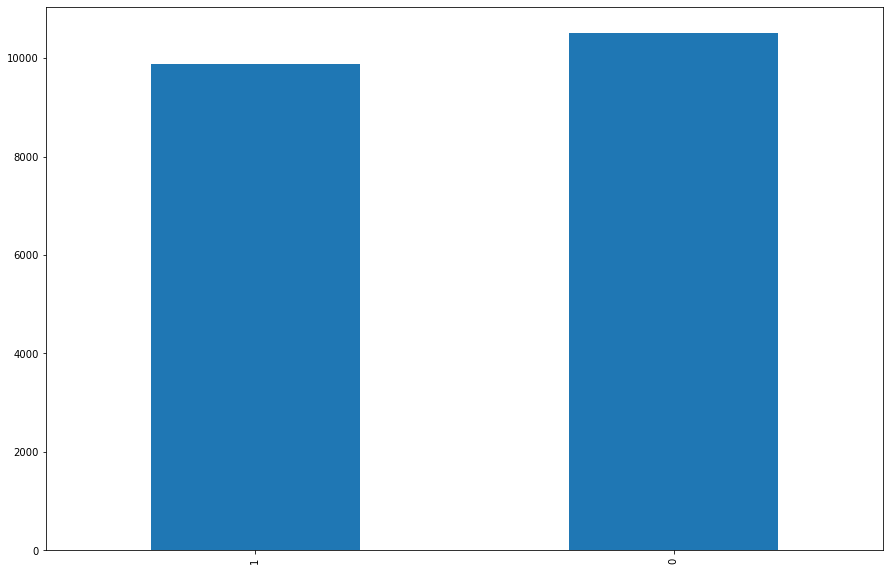

In [4]:
df['class'].value_counts(sort = False).plot.bar(color='#1f77b4')

---

# Data Preparation

## Feature extraction

In this step, we'll extract the features that we will later used to convert each sentence into a vector. Let's store all the estimates as subdictionaries of a `features_dictionary` dictionary of dictionaries:

In [4]:
# Keys are feature names, values are dictionaries mapping sentence indices to feature values
features_dictionary = dict() 

**1.** **Number of tokens in each sentence** (0.5 points)

Calculate the number of tokens (i.e. linguistic units) in each sentence. 

Store these numbers in a `features_dictionary` sub-dictionary labelled `tokens_counts`, whose keys are the `sentence_id` and the values are the number of tokens of each sentence. 

**Answer.**

In [5]:
tokens_counts = dict()
i = 0
for sentence in df_dict['raw_sentence'].values():
    key = list(df_dict['raw_sentence'].keys())[i]
    token_list = sentence.split()
    number_of_tokens = len(token_list)
    tokens_counts[key] = number_of_tokens 
    i += 1

features_dictionary["tokens_counts"] = tokens_counts

In [6]:
def test_token_counts():
    key = 'tokens_counts'
    assert len(features_dictionary) == 1, 'features_dictionary should contain a single key "tokens_counts"'
    assert len(features_dictionary[key]) == len(df), f"{len(features_dictionary[key])} {key}, {len(df)} sentences"
    assert all([el >= 0 for el in features_dictionary[key].values()]), f'{key} should be non-negative'
    assert all([type(el) == int for el in features_dictionary[key].values()]), f'{key} should be integers'
    assert set(features_dictionary[key].keys()) == set(df.index.tolist()), f'{key} indices should match sentence ids'

test_token_counts()

**2.** **Number of characters in each sentence** (0.5 points)

Calculate the number of characters in each **lemmatized sentence**. 

Store this estimates in a `features_dictionary` sub-dictionary labelled `characters_counts`, whose keys are the `sentence_id` and the values are the number of characters of each sentence. 

**Answer.**

In [7]:
characters_counts = dict()
i = 0
for sentence in df_dict['raw_sentence'].values():
    key = list(df_dict['raw_sentence'].keys())[i]
    characters_counts[key] = len(sentence) 
    i += 1

features_dictionary["characters_counts"] = characters_counts

In [8]:
def test_char_counts():
    key = 'characters_counts'
    assert len(features_dictionary) == 2, 'features_dictionary keys should be "tokens_counts" and "characters_counts"'
    assert len(features_dictionary[key]) == len(df), f"{len(features_dictionary[key])} {key}, {len(df)} sentences"
    assert all([el >= 0 for el in features_dictionary[key].values()]), f'{key} should be non-negative'
    assert all([type(el) == int for el in features_dictionary[key].values()]), f'{key} should be integers'
    assert set(features_dictionary[key].keys()) == set(df.index.tolist()), f'{key} indices should match sentence ids'

test_char_counts()

**3.** **n-grams features** (1 point)

As you have learned (or will shortly learn) in *Computationele Linguistiek*, a common way to enhance features is to use $n$-grams, i.e., a contiguous sequence of $n$ words. Write a piece of code that:

a) finds the 200 most frequent $n$-grams in our *lemmatized* sentences, with $n$ equal to 1, 2, or 3. Store these $n$-grams in a set called `most_frequent_ngrams`

b) counts how many times each of these `most_frequent_ngrams` appears in each sentence and stores these estimates in a dictionary of dictionaries called `ngrams_frequencies`, in which the keys are the $n$-grams (e.g. `my god`) and the values are dictionaries of the form `{sentence_id : occurrences_of_this_ngram}`. 

*Hint*: the `nltk.ngrams(sequence, n)` method can be used to generate all the possible length-$n$ $n$-grams from a sequence, as in the following examples (ignore eventual `DeprecationWarning` warnings):

In [11]:
print(list(nltk.ngrams(["I", "came", "here", "to", "rescue", "you", "from", "him"], 2)))
print(list(nltk.ngrams(["I", "came", "here", "to", "rescue", "you", "from", "him"], 3)))

[('I', 'came'), ('came', 'here'), ('here', 'to'), ('to', 'rescue'), ('rescue', 'you'), ('you', 'from'), ('from', 'him')]
[('I', 'came', 'here'), ('came', 'here', 'to'), ('here', 'to', 'rescue'), ('to', 'rescue', 'you'), ('rescue', 'you', 'from'), ('you', 'from', 'him')]


**Answer.**

In [39]:
most_frequent_ngrams = set()
ngram_count = dict()
for index,sent in enumerate(df["lemmatized_sentence"]):
    lemma_sent = [lemmatized_word for (normal_word,lemmatized_word) in sent] # Get the lemmatized version of the word
    for n in range(3):
        ngrams = list(nltk.ngrams(lemma_sent, n+1)) # Get ngrams
        for ngram in ngrams:
            if ngram in ngram_count: # Standard counter
                ngram_count[ngram]+=1
            else:
                ngram_count[ngram] =1

counted_ngrams = sorted(ngram_count.items(), key=lambda item:item[1],reverse=True)[0:200] # Sort the most frequent ngrams by count
for count in counted_ngrams:
    most_frequent_ngrams.add(count[0]) # Most frequent ngrams added to the set

sentence_ids = sorted(df_dict['raw_sentence'].keys())
ngrams_frequencies = dict()
for i in most_frequent_ngrams:
    occurences_dict = dict()
    for index,sent in enumerate(df["lemmatized_sentence"]): # Most frequent ngram per sentence
        lemma_sent = [lemmatized_word for (normal_word,lemmatized_word) in sent]
        ngrams = list(nltk.ngrams(lemma_sent, len(i)))
        count = 0
        for j in ngrams:
            if i == j:
                count += 1
        occurences_dict.update({index : count})
    ngrams_frequencies[i] = occurences_dict

## Reorganizing our features

Up to this moment, we have organized our features into the following dictionaries:

1. `ngrams_frequencies`: a group of lexical features, encoding how many times a given sequence of words (i.e. an n-gram) occurs in each sentence

1. `features_dictionary`: the numbers of tokens and characters in each sentence

In order to train our models, we're going to convert these dictionaries into matrices, where each row vector represent a single sentence. 

The following script converts the `features_dictionary` into a `other_features_matrix`, whose columns are the keys of `features_dictionary`, and the rows are the sentence ids. Similarly, it converts `ngrams_frequencies` into `ngrams_matrix`.

In [29]:
def to_matrix(feature_dict: dict, sentence_ids: list) -> np.ndarray:
    # feature_dict is one of features_dictionary, ngrams_frequencies
    feature_names = feature_dict.keys()
    # let's create a matrix of zeros and populate it by iterating over our dictionary 
    feature_matrix = np.zeros((len(sentence_ids), len(feature_names)))
    for fix, feature_name in enumerate(feature_names):
        for tix, sentence_id in enumerate(sentence_ids):
            feature_matrix[tix, fix] = feature_dict[feature_name][sentence_id]
    return feature_matrix

In [31]:
sentence_ids = sorted(df_dict['raw_sentence'].keys())

other_features_matrix = to_matrix(features_dictionary, sentence_ids)
ngrams_matrix = to_matrix(ngrams_frequencies, sentence_ids)

a = 1

## Target variable

Next, we create an array with the class label for each sentence.

In [32]:
sentence_classes = np.asarray([df_dict['class'][i] for i in sentence_ids])

## Weighting the lexical feature frequencies

Absolute frequencies may be a deceiving source of information: a word may appear frequently in a sentence simply due to its overall high frequency, while the use of an overall rare word may be an useful semantic or pragmatic clue. As a consequence, it is common practice to **weight** the frequency of a word so as to take into account its overall distribution (sometimes, along with the distribution of all the words in the corpus). 

Probably the most widely used statistic in information retrieval and text mining is the [term frequency-inverse document frequency (tf-idf)](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), in which the weigth of each term $t$ in each document $d$ is estimated as:

$$\text{tf-idf}_{t,d} = \text{tf}_{t,d} \times \text{idf}_t = \text{tf}_{t,d} \times log \left( \frac{N}{\text{df}_t}\right)$$

- where:
    - tf$_{t,d}$ is the number of occurrences of term $t$ in document $d$ (the term frequency)
    - $N$ is the total number of documents
    - df$_t$ is the number of documents in which term $t$ appears (the document frequency)
    
We transform `ngrams_matrix` into tf-idf representations called `ngrams_matrix_tfidf` using the `TfidfTransformer()` from sklearn (see the [docs](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) for more info).

In [33]:
# let's weight our matrix (norm="l1" because we chose to adjust the term frequency for document length)
ngrams_matrix_tfidf = TfidfTransformer(norm="l1").fit_transform(ngrams_matrix).todense()

## Merging our feature matrices

**4. Merging our feature matrices** (0.5 points)

Create a feature matrix by merging the non-lexical features with the lexical feature set

- `features_set_ngrams`, obtained by merging `other_features_matrix` and `ngrams_matrix_tfidf`


*Hint*: the numpy.concatenate() method can be used to concatenate two matrices

**Answer.**

In [34]:
features_set_ngrams = np.concatenate((other_features_matrix, ngrams_matrix_tfidf), axis=1)

## Dataset splitting

**5. Development and Test Set** (0.5 points)

As a first step, split the whole dataset into a development and a test set: randomly select 10% of the sentences to be used in the next phase of this activity (i.e. "Test the best performing model"). This is done mainly to prevent our models from over-fitting the training data.

The remaining 90% of our sentences will compose the development set on which we are going to train our model.

Divide the ids of our matrix into a test set (approximately 10% of the ids of the rows of our matrices) and a development set (the remaining rows)

**Answer.**

In [35]:
np.random.shuffle(sentence_ids)
testset = sentence_ids[int(len(sentence_ids) * .0) : int(len(sentence_ids) * .10)]
developset = sentence_ids[int(len(sentence_ids) * .10) : int(len(sentence_ids) * 1)]

---

# Logistic Regression

In the second step, we will see how a Machine Learning algorithm we discussed in class, Logistic Regression, performs with the dataset we've created in the previous phase. For implementing Logistic Regression, we'll use the `linear_model` module available in the `scikit-learn` library (**please note that you are not allowed to use any other module of this library**)

## Implementing our ML algorithm

The following example shows how you can use the `scikit-learn` library to implement Logistic Regression:

In [15]:
# some dummy datasets

X_train = np.random.randint(3, size=(20, 6))  # dummy datatset of training data
X_test = np.random.randint(3, size=(5, 6))  # dummy datatset of test data

y_train = np.random.randint(3, size=20)  # dummy labels for the training data
y_test = np.random.randint(3, size=5)  # dummy labels for the test data

In [16]:
# a minimal Logistic Regression

# Create logistic regression object
regr = linear_model.LogisticRegression(solver='lbfgs', multi_class='multinomial')

#Train the model using the training sets
regr.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = regr.predict(X_test)

Having trained a model, you would then estimate its performance by comparing `y_pred` (the predicted labels) and `y_test` (the gold standard)

## Performance Measures

To evaluate the quality of a model, we generate predictions on a held-out set (for which we have the correct annotations) and we calculate:

**Accuracy**: the percentage of inputs documents (i.e., sentences) correctly classified

**Precision, Recall and F-measure** are calculated from the following estimates:

- True Positives: fraction of sentences that we correctly identified as relevant
- True Negatives: fraction of sentences that we correctly identified as irrelevant
- False Positives (or Type I errors): irrelevant sentences that we incorrectly identified as relevant
- False Negatives (or Type II errors): relevant sentences that we incorrectly identified as irrelevant

<img src="https://www.nltk.org/images/precision-recall.png" alt="drawing" width="600"/>

- **Precision**: how many of the items that we identified as relevant were actually relevant: $\frac{\text{TP}}{(\text{TP}+\text{FP})}$.


- **Recall**: how many of the relevant items we identified we identified as relevant, is $\frac{\text{TP}}{(\text{TP}+\text{FN})}$,


- **F$_1$-measure**: the harmonic mean of the precision and recall: $2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$

## Cross-validation

Below we will train our logistic regression model with two feature sets:

- `other_features_matrix` alone

- `features_set_ngrams`, which includes `other_features_matrix` as well as our $n$-grams features

When comparing different models, it is better to perform multiple evaluations on different portions of our develpment set, and then combining the scores from those evaluations. This techinique is called **cross validation**.

Now, we will divide our development set into **5 subsets** called folds. For each fold, we train our models using all the data in the develpment set except those in this fold, and then we test our models on this fold. We then combine our evaluation to compute the overal score of our models. 

### Using NumPy

Some of the computations you will perform below, such as creating a training set from the development set, will require selecting some elements from a NumPy array or matrix. We actively encourage you to perform such operations using matrices entirely, i.e., using NumPy methods such as `numpy.take`, rather than to create `for` loops. Practice with NumPy will be essential in your follow-up course *Machine Learning*.

**6. Logistic regression training and cross validation** (2 points). Follows these steps to compare our settings:

1. Shuffle development dataset (you may consider using the `random.shuffle()` method)

2. Split the shuffled development set into 5 groups (you may consider using the `np.array_split()` method)

3. For each fold:
    - take the fold as the held-out data set and the remaining folds together as a training set
    - train Logistic Regression with each feature setting (lemmas vs. ngrams) on the training set
    - evaluate each ML algorithm + feature setting on the held-out set
    - for each model (manually, i.e., without using existing libraries) calculate accuracy, precision, recall and f-measure and store these results
    
4. for each feature setting, average the performance measures over all the folds in cross-validation (this is called **macro-averaging**)

5. choose the best performing feature setting

**Answer.**

In [36]:
def evaluate(y_pred, y_target):
    tn = 0
    fp = 0
    fn = 0
    tp = 0
    
    for i in range(len(y_pred)):
        if y_pred[i] == 1:
            if y_target[i] == 1:
                tp += 1
            else:
                fp += 1
        if y_pred[i] == 0:
            if y_target[i] == 1:
                fn += 1
            else:
                tn += 1
                
    accuracy = (tp + tn) / len(y_pred)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    fmeasure = 2 * ((precision*recall)/(precision+recall))
    return accuracy, precision, recall, fmeasure, tp, tn, fp, fn
    
def logistic_regression():
    np.random.shuffle(developset)
    np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) #Disable warnings (problem is generated in regr.fit(not my code))

    accuracy_other = []
    precisions_other = []
    recalls_other = []
    fmeasures_other = []

    accuracy_ngrams = []
    precisions_ngrams = []
    recalls_ngrams = []
    fmeasures_ngrams = []

    features = [other_features_matrix, features_set_ngrams]
    featurecount = 0
    foldcount = 0
    split_developset = np.array_split(developset, 5)
    for fold in split_developset:
        heldout = fold
        trainingset = np.delete(split_developset, foldcount, 0)

        for feature in features:

            # Create logistic regression object
            regr = linear_model.LogisticRegression(solver='lbfgs', multi_class='multinomial')

            #Train the model using the feature_matrix
            wanted_sentence_ids = []
            for i in trainingset:
                for j in i:
                    wanted_sentence_ids.append(j)

            x_train = feature[wanted_sentence_ids]
            y_train = sentence_classes.T[wanted_sentence_ids]
            regr.fit(x_train, y_train)

            #Predict the response for test dataset
            heldout_sentence_ids = []
            for i in heldout:
                heldout_sentence_ids.append(i)
            x_test = feature[heldout_sentence_ids]
            y_pred = regr.predict(x_test)

            if featurecount in [0, 2, 4, 6, 8]:
                fold_eval = evaluate(y_pred, sentence_classes)
                accuracy_other.append(fold_eval[0])
                precisions_other.append(fold_eval[1])
                recalls_other.append(fold_eval[2])
                fmeasures_other.append(fold_eval[3])
            else:
                fold_eval = evaluate(y_pred, sentence_classes)
                accuracy_ngrams.append(fold_eval[0])
                precisions_ngrams.append(fold_eval[1])
                recalls_ngrams.append(fold_eval[2])
                fmeasures_ngrams.append(fold_eval[3])

            featurecount += 1
    return accuracy_other, precisions_other, recalls_other, fmeasures_other, accuracy_ngrams, precisions_ngrams, recalls_ngrams, fmeasures_ngrams


## Model evaluation on a test set

**7. Test the best performing model** (1 point)

Assess the performance of the better model identified in the previous step. For this evaluation, we will use as training set the full development set that we've used fro the 5-folds cross-validation, corresponding to 90% of our sentences). We will then evaluate out model on the remaining 10% of sentences that we've never used (up to now), i.e. the `test set`.

We will compare the prediction of our model against the human annotations and we will **manually** calculate:

- its accuracy

- its precision, recall and f-measure

- the confusion matrix (fell free to use the `matplotlib.pyplot.imshow()` method to plot it, but bear in mind that the confusion matrix should be calculated manually)

**Answer.**

In [37]:
x = logistic_regression()
avg_accuracy_other = sum(x[0]) / len(x[0])
avg_precision_other = sum(x[1]) / len(x[1])
avg_recalls_other = sum(x[2]) / len(x[2])
avg_fmeasures_other = sum(x[3]) / len(x[3])

avg_accuracy_ngrams = sum(x[4]) / len(x[4])
avg_precision_ngrams = sum(x[5]) / len(x[5])
avg_recalls_ngrams = sum(x[6]) / len(x[6])
avg_fmeasures_ngrams = sum(x[7]) / len(x[7])


print("Result of other_features_matrix:"
      f"\nAccuracy = {avg_accuracy_other}"
      f"\nPrecision = {avg_precision_other}"
      f"\nRecalls = {avg_recalls_other}"
      f"\nF-Measure = {avg_fmeasures_other}"
      "\n"
      "\nResult of feature_set_matrix:"
      f"\nAccuracy = {avg_accuracy_ngrams}"
      f"\nPrecision = {avg_precision_ngrams}"
      f"\nRecalls = {avg_recalls_ngrams}"
      f"\nF-Measure = {avg_fmeasures_ngrams}"
      )

C:\Users\Thijmen\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Thijmen\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

Result of other_features_matrix:
Accuracy = 0.5005440094861153
Precision = 0.5271594240416613
Recalls = 0.44918190067873265
F-Measure = 0.4850419656571766

Result of feature_set_matrix:
Accuracy = 0.5022331599790859
Precision = 0.5242083444353325
Recalls = 0.5344836561412507
F-Measure = 0.5292819895862632


C:\Users\Thijmen\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


---

# Neural Networks

Now instead of logistic regression we will experiment with neural networks for this classification task. For this, you will need to install tensorflow (e.g. via Anaconda) if you haven't already.

In [41]:
import tensorflow as tf

The goal of this exercise is not to find a classifier with the best out-of-sample performance, but rather to see the practical impact of various choices in setting up a neural network (some of which you have seen in the lecture, some not).

We will use Keras, which is a higher-level interface that can be used on top of tensorflow. It makes many common deep learning tasks very easy to perform. The following code sets up a simple neural network with one hidden layer of 20 neurons. We will use the Stochastic Gradient Descent (SGD) optimizer; see documentation here: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD

In [42]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(2, activation='softmax')
])
sgd = tf.keras.optimizers.SGD()
model.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

The hidden layer uses `tanh` as its nonlinear activation function. The output layer uses `softmax`, which is also a smooth nonlinear function, but has the special property that it transforms an arbitrary real-valued vector into a vector of numbers between 0 and 1, summing to 1. These values are interpreted as likelihoods for the classes, just as for logistic regression. The network is trained to minimize the loss function `sparse_categorical_crossentropy`, which corresponds to maximizing that likelihood, again like logistic regression.

**Note:** A loss function `categorical_crossentropy` also exists in Keras. If the labels were encoded as "one-hot" vectors instead of as integers, `categorical_crossentropy` would be the right loss function to use instead of the `sparse_` one.

**8. Train a simple neural network** Using `features_set_ngrams`, fit this model to your development data (with `epochs=30`; in each "epoch", all data points are passed through the network forward and backward once). Then evaluate the model on the test data (1 points)

**Answer.**

In [48]:
import time
ids = np.array([i for i, v in enumerate(features_set_ngrams)])
trainings_x = features_set_ngrams[ids]

trainings_y = sentence_classes[ids]

model.fit(trainings_x, trainings_y, epochs=30)

Epoch 1/30
638/638 [==============================] - 1s 1ms/step - loss: 0.5439 - accuracy: 0.7406
Epoch 2/30
638/638 [==============================] - 1s 1ms/step - loss: 0.5540 - accuracy: 0.7358
Epoch 3/30
638/638 [==============================] - 1s 1ms/step - loss: 0.5436 - accuracy: 0.7438
Epoch 4/30
638/638 [==============================] - 1s 1ms/step - loss: 0.5483 - accuracy: 0.7399
Epoch 5/30
638/638 [==============================] - 1s 1ms/step - loss: 0.5431 - accuracy: 0.7468
Epoch 6/30
638/638 [==============================] - 1s 1ms/step - loss: 0.5490 - accuracy: 0.7395
Epoch 7/30
638/638 [==============================] - 1s 1ms/step - loss: 0.5359 - accuracy: 0.7504
Epoch 8/30
638/638 [==============================] - 1s 1ms/step - loss: 0.5451 - accuracy: 0.7437
Epoch 9/30
638/638 [==============================] - 1s 1ms/step - loss: 0.5422 - accuracy: 0.7441
Epoch 10/30
638/638 [==============================] - 1s 1ms/step - loss: 0.5331 - accuracy: 0.7533

**9. Neural network parameter exploration** (2 points)

The `model.fit` function returns a History object, which stores among other things the training (in-sample) losses per epoch. If the History object is called `hist[i]`, the losses are `hist[i].history['loss']`.

Use this to plot the training losses per epoch for three different values of the `learning_rate` (the step size $\eta$, or "eta", used by stochastic gradient descent): 0.1, 0.01 (the default), and 0.001. (To write your solution, start by copy-pasting the code from above and putting a for-loop around it.)
What do you observe?

Similarly experiment with each of the following aspects of the neural network:
* You can pass different values of `batch_size` to `model.fit`. For `batch_size=1`, we get standard Stochastic Gradient Descent (SGD) where the gradient is computed for one data point at a time. For a batch size at least as large as the training data, the gradient is computed for all these data points together (this is batch GD). The default value of 32 is in between these two extremes (this is called a "minibatch");
* Gradient descent only looks at the gradient, and only at the point of the current weights. More advanced optimizers take more information into account, such as second derivatives and recently visited points. A popular choice is `optimizer='adam'` instead of `optimizer=sgd`;
* The number of epochs used when fitting the model (if the 30 epochs we chose before led to worse performance than logistic regression, try increasing the number of epochs; see if the accuracy seems to be converging);
* The activation function in the hidden layer (e.g. `'relu'` instead of `'tanh'`);
* The number of neurons in the hidden layer.

For each of these, write code that tries out models with different values of that setting, while keeping all other settings constant at values you choose based on the previous experiments. Your code must produce relevant output when the notebook is run. This can be one of many different things, e.g. training losses per epoch, test accuracy, computation time, ..., so for each setting, pick one that you expect to be interesting, and write code to measure it. In the corresponding text cell, write down your conclusions from your code's output.

**Answer.**

Epoch 1/30
638/638 [==============================] - 1s 1ms/step - loss: 0.7090 - accuracy: 0.5023
Epoch 2/30
638/638 [==============================] - 1s 2ms/step - loss: 0.7089 - accuracy: 0.4987
Epoch 3/30
638/638 [==============================] - 2s 3ms/step - loss: 0.7134 - accuracy: 0.4961
Epoch 4/30
638/638 [==============================] - 1s 1ms/step - loss: 0.7127 - accuracy: 0.4997
Epoch 5/30
638/638 [==============================] - 2s 3ms/step - loss: 0.7126 - accuracy: 0.4957
Epoch 6/30
638/638 [==============================] - 2s 3ms/step - loss: 0.7100 - accuracy: 0.5041
Epoch 7/30
638/638 [==============================] - 1s 2ms/step - loss: 0.7092 - accuracy: 0.5023
Epoch 8/30
638/638 [==============================] - 3s 4ms/step - loss: 0.7103 - accuracy: 0.4999
Epoch 9/30
638/638 [==============================] - 1s 2ms/step - loss: 0.7127 - accuracy: 0.4980
Epoch 10/30
638/638 [==============================] - 1s 1ms/step - loss: 0.7101 - accuracy: 0.5020

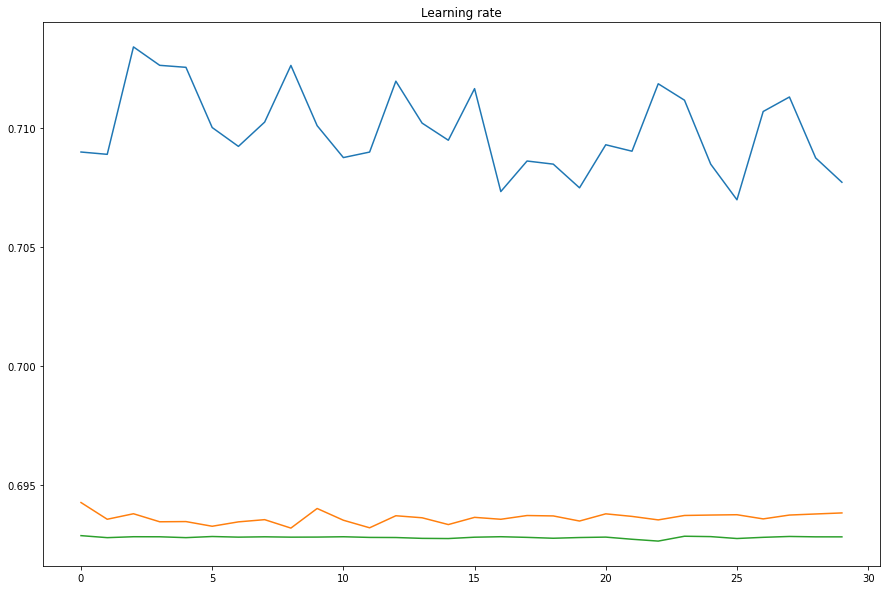

In [62]:
learningrates = [0.1, 0.01, 0.001]
history = []

for i in learningrates:
    model.optimizer.learning_rate = i
    history.append(model.fit(trainings_x, trainings_y, epochs=30))

for i in range(len(history)):
    x = np.arange(30)
    y = history[i].history['loss']

    plt.plot(x, y, label = f"learningrates = {learningrates[i]}")
    plt.title("Learning rate")
    plt.legend()
    plt.show

learning rate: The lower the learning rate, the worse it is

638/638 [==============================] - 2s 3ms/step - loss: 0.6928 - accuracy: 0.5155


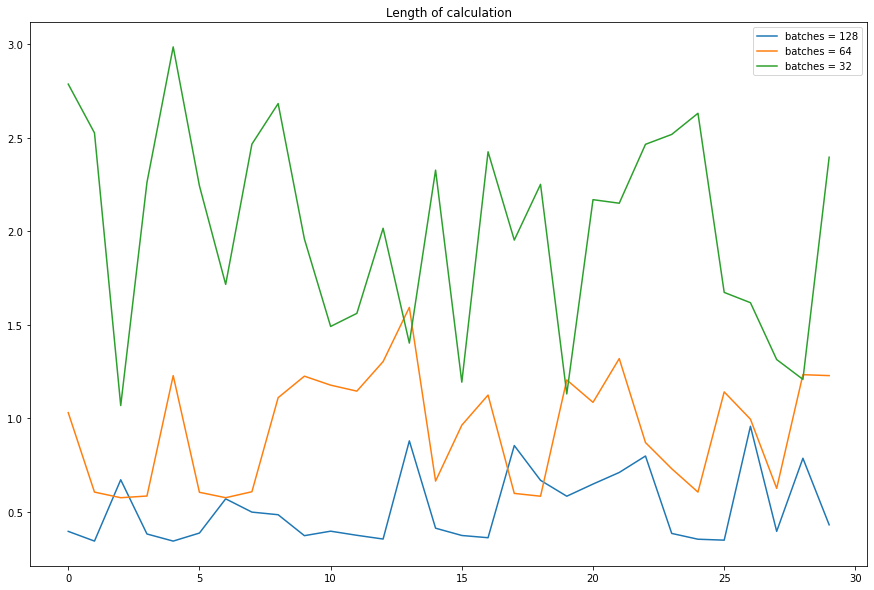

In [63]:
timelist = []
for i in [128, 64, 32]:
    times = []
    for j in range(30):
        begin = time.time()
        model.fit(trainings_x, trainings_y, epochs=1, batch_size=i)
        runtime = round(time.time()-begin, 3)
        times.append(runtime)
    timelist.append(times)

for i in range(len(history)):
    x = np.arange(30)
    y = timelist[i]
    plt.plot(x, y, label = f"batches = {[128, 64, 32][i]}" )
    plt.title("Length of calculation")
    plt.legend()
plt.show()

batch size: How more batches there are, how less time it takes to compute.

Epoch 1/30
638/638 [==============================] - 1s 2ms/step - loss: 0.6928 - accuracy: 0.5149
Epoch 2/30
638/638 [==============================] - 1s 2ms/step - loss: 0.6928 - accuracy: 0.5155
Epoch 3/30
638/638 [==============================] - 1s 2ms/step - loss: 0.6928 - accuracy: 0.5155
Epoch 4/30
638/638 [==============================] - 2s 3ms/step - loss: 0.6928 - accuracy: 0.5155
Epoch 5/30
638/638 [==============================] - 1s 2ms/step - loss: 0.6928 - accuracy: 0.5155
Epoch 6/30
638/638 [==============================] - 1s 2ms/step - loss: 0.6928 - accuracy: 0.5155
Epoch 7/30
638/638 [==============================] - 1s 2ms/step - loss: 0.6928 - accuracy: 0.5155
Epoch 8/30
638/638 [==============================] - 1s 1ms/step - loss: 0.6928 - accuracy: 0.5155
Epoch 9/30
638/638 [==============================] - 1s 2ms/step - loss: 0.6928 - accuracy: 0.5155
Epoch 10/30
638/638 [==============================] - 2s 3ms/step - loss: 0.6928 - accuracy: 0.5155

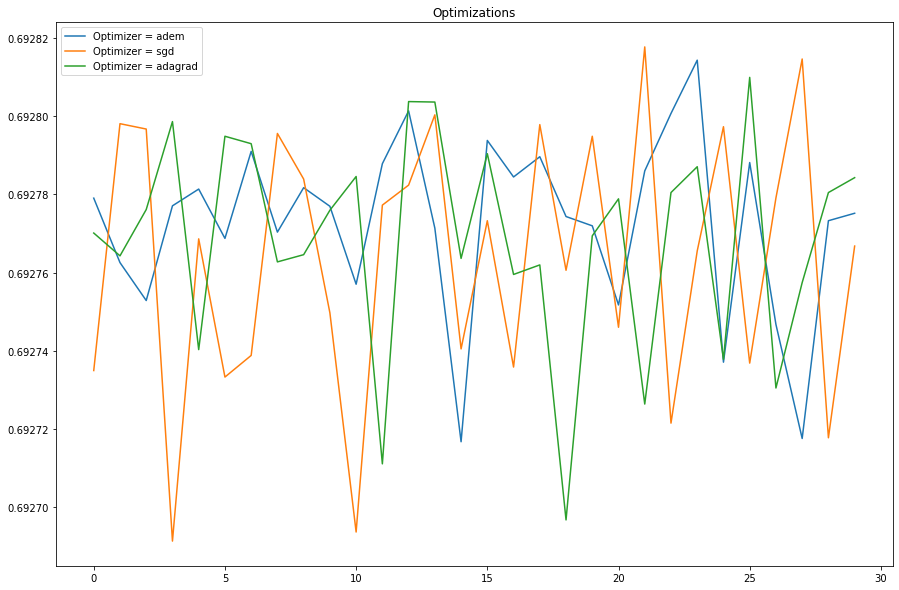

In [66]:
optima = ["adem", "sgd", 'adagrad']
history = []

for prime in optima:
    model.optimizer.Optimizer = prime
    history.append(model.fit(trainings_x, trainings_y, epochs=30))

for i in range(len(history)):
    x = np.arange(30)
    y = history[i].history['loss']
    plt.title("Optimizations")
    plt.plot(x, y, label = f"Optimizer = {optima[i]}" )
    plt.legend()
plt.show()

optimizer: There not a clear winner here. These optimizers are almost identical.

In [46]:
epochs = [1, 10, 50]
history = []
avg_accuracy = []
for i in epochs:
    avg_accuracy.append(sum(model.fit(trainings_x, trainings_y, epochs=i).history['accuracy'])/i)

for i in range(len(history)):
    plt.title("Epoch accuracy")
    plt.bar(epochs, avg_accuracy)
    plt.legend()
plt.show()

638/638 [==============================] - 1s 1ms/step - loss: 0.5813 - accuracy: 0.7086
Epoch 1/10
638/638 [==============================] - 1s 1ms/step - loss: 0.5771 - accuracy: 0.7106
Epoch 2/10
638/638 [==============================] - 1s 1ms/step - loss: 0.5729 - accuracy: 0.7166
Epoch 3/10
638/638 [==============================] - 1s 1ms/step - loss: 0.5753 - accuracy: 0.7111
Epoch 4/10
638/638 [==============================] - 1s 1ms/step - loss: 0.5795 - accuracy: 0.7113
Epoch 5/10
638/638 [==============================] - 1s 1ms/step - loss: 0.5758 - accuracy: 0.7115
Epoch 6/10
638/638 [==============================] - 1s 1ms/step - loss: 0.5750 - accuracy: 0.7150
Epoch 7/10
638/638 [==============================] - 1s 1ms/step - loss: 0.5762 - accuracy: 0.7136
Epoch 8/10
638/638 [==============================] - 1s 1ms/step - loss: 0.5779 - accuracy: 0.7128
Epoch 9/10
638/638 [==============================] - 1s 1ms/step - loss: 0.5730 - accuracy: 0.7129
Epoch 10/10

epochs: We see that the higher the epochs, the higher the accuracy because you train the model more often so it becomes better and better (at least for this dataset, maybe not for others (overfitting))

Epoch 1/15
638/638 [==============================] - 1s 1ms/step - loss: 0.5353 - accuracy: 0.7510
Epoch 2/15
638/638 [==============================] - 1s 1ms/step - loss: 0.5379 - accuracy: 0.7503
Epoch 3/15
638/638 [==============================] - 1s 1ms/step - loss: 0.5316 - accuracy: 0.7536
Epoch 4/15
638/638 [==============================] - 1s 1ms/step - loss: 0.5280 - accuracy: 0.7605
Epoch 5/15
638/638 [==============================] - 1s 1ms/step - loss: 0.5294 - accuracy: 0.7569
Epoch 6/15
638/638 [==============================] - 1s 1ms/step - loss: 0.5446 - accuracy: 0.7451
Epoch 7/15
638/638 [==============================] - 1s 1ms/step - loss: 0.5347 - accuracy: 0.7518
Epoch 8/15
638/638 [==============================] - 1s 1ms/step - loss: 0.5272 - accuracy: 0.7562
Epoch 9/15
638/638 [==============================] - 1s 1ms/step - loss: 0.5272 - accuracy: 0.7564
Epoch 10/15
638/638 [==============================] - 1s 1ms/step - loss: 0.5322 - accuracy: 0.7538

<BarContainer object of 5 artists>

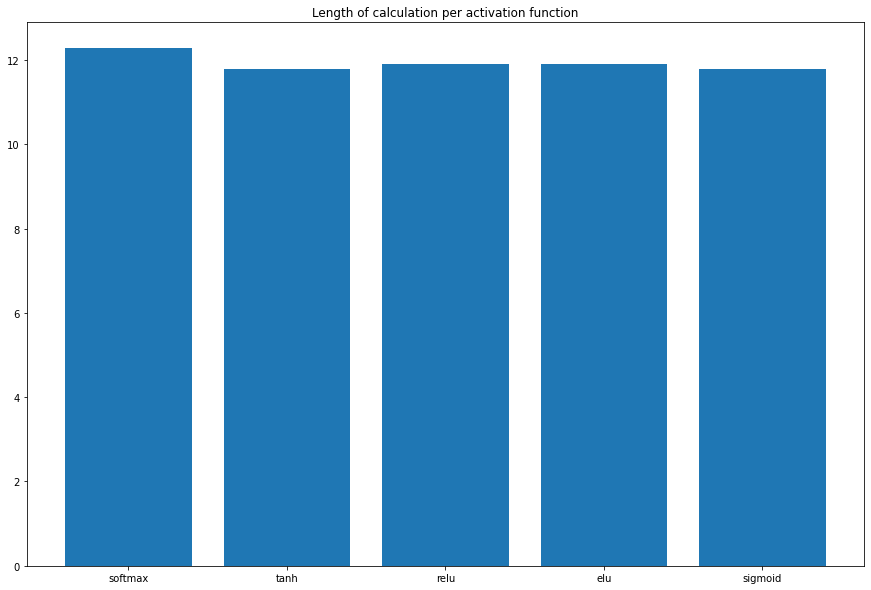

In [49]:
functions = ['softmax', 'tanh', 'relu', 'elu', 'sigmoid']

history = []
timelist = []
for func in functions:
    model.add(tf.keras.layers.Activation(func))

    begin = time.time()
    history.append(model.fit(trainings_x, trainings_y, epochs=15))
    runtime = round(time.time()-begin, 3)
    timelist.append(runtime)

plt.title("Length of calculation per activation function")
plt.bar(functions, [t for t in timelist])

activation function: They all take just as long as each other except for softmax, that one takes somewhat longer. So it is a harder function to compute.

In [ ]:
# number of neurons: your code here

number of neurons: your answer here

---

# Questions

**10.** What was your better logistic regression model? Intuitively, why do you think that it performed better? (0.5 points)

**Answer**

The feature_set_ngrams model is somewhat better than the other model because it contains that model and the ngram feature set.

**11.** Did the neural networks perform better or worse than logistic regression? How can you interpret that result? (0.5 points)

**Answer**

The neural networks performed better just because they are more complex and more capable to learn. Also, we use more epochs so it is learning multiple times to our data.